In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection
from random import choices
from imageio import imread




# SHAPER
from src.Observables import Observable
from src.CommonObservables import buildCommmonObservables
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals

import torch 
import torch.nn as nn



# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event

# Jets
from pyjet import cluster


# GPU nonsense
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 



/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


In [2]:


# Parameters
R = 0.5
beta = 1.0
N = 50
batch_size = min(5000,N)
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N, amount = 1)
# sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N, amount = 1)

In [3]:
def squarify(M,val):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1,:]) / 255.0
    img = 1 - img
    mask = img > 0
    # img[mask] = 1
    img = 1 - img

    area = np.sum(img[img > 0] / (img.shape[0] * img.shape[1]))
    print(area)

    img = squarify(img,0)
    plt.imshow(img)
    plt.show()
    return img, area

fname = "mu.jpg"
def boost_samples(n, param_dict, dtype=torch.FloatTensor):
    A, area = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(-0.5, 0.5, A.shape[0]),
        np.linspace(-0.5, 0.5, A.shape[1]),
        indexing="xy",
    )


    print(A.shape)
    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    print(sum(dens))
    # dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return (dots, np.ones((n,)) / n), area


def display_samples(x, color = "red"):
    plt.scatter(x[:, 0], x[:, 1], 25 * 500 / len(x), color = 'black', edgecolors="none")
    plt.show()


0.25624271063618365


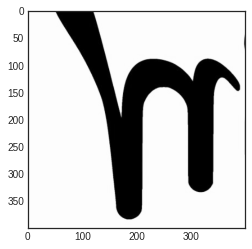

(400, 400)
1.0000001551583608


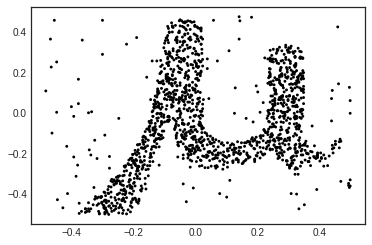

In [4]:
fig, ax = plt.subplots()


(x, z), area = boost_samples(1500, {})
display_samples(x)
plt.show()

event = (x, z)
events = (event,)

# Energy Density (for plotting purposes):
density = 1.0 / area


In [ ]:
from matplotlib.collections import PathCollection
from matplotlib.patches import Rectangle as pltRectangle
from matplotlib.patches import Ellipse as pltEllipse
from matplotlib.patches import Circle as pltCircle


commonObservables, obsarray = buildCommmonObservables(100, 1, R, device)

_5ellipsiness = commonObservables["5-Ellipsiness"]
_10ellipsiness = commonObservables["10-Ellipsiness"]
_25ellipsiness = commonObservables["25-Ellipsiness"]
_50ellipsiness = commonObservables["50-Ellipsiness"]
_100ellipsiness = commonObservables["100-Ellipsiness"]



def temp_plotter_2(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii1 = param_dict["Radius1"].params.clone().detach().numpy()
    radii2 = param_dict["Radius2"].params.clone().detach().numpy()
    angles = param_dict["Angles"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy() 
    num = param_dict["Points"].N

    for i in range(num):
        
        # Circle
        area_i = np.pi * radii1[i] * radii2[i]
        density_i = np.nan_to_num(weights[i] / (np.pi * radii1[i] * radii2[i]), 1.0)
        if weights[i] == 0:
            density_i = 0
        draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "purple", edgecolor = "purple", alpha = min(0.5, 0.25 * density_i / density), zorder = 12)
        ax.add_artist(draw_circle)

        draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "none", edgecolor = "purple", alpha = min(0.75, 0.5 * density_i / density))
        ax.add_artist(draw_circle)

      
        # Text
        eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        # plt.text(0.05, 0.15 + 0.10*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (centers[i,0], centers[i,1], weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)
        # plt.text(0.05, 0.10 + 0.10*i, r"    Eff. Rad: %.2f, Ecc: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity), fontsize = 18, transform = plt.gca().transAxes)

        # plt.text(0.05, 0.10 + 0.05*i, s + r"Eff. Rad: %.2f, Ecc: %.2f, z$_\mathcal{O}$: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity, weights[i], ), fontsize = 18, transform = plt.gca().transAxes)


    # plt.text(0.05, 0.10 + 0.05*num, r"z$_{PU}$: %.2f" % (pileup), fontsize = 18, transform = plt.gca().transAxes)
    # draw_rect = pltRectangle( (-R*0.9, -R*0.9), 2*R*0.9, 2*R*0.9, angle = 0, facecolor = "purple", edgecolor = "purple", alpha = 0.50 * pileup)
    # ax.add_artist(draw_rect)    

_5ellipsiness.plotter = temp_plotter_2
_10ellipsiness.plotter = temp_plotter_2
_25ellipsiness.plotter = temp_plotter_2
_50ellipsiness.plotter = temp_plotter_2
_100ellipsiness.plotter = temp_plotter_2


_5ellipsiness.initializer = None
_10ellipsiness.initializer = None
_25ellipsiness.initializer = None
_50ellipsiness.initializer = None
_100ellipsiness.initializer = None


obs = {
       "5-Ellipsiness" : _5ellipsiness,
       "10-Ellipsiness" : _10ellipsiness,
       "25-Ellipsiness" : _25ellipsiness,
       "50-Ellipsiness" : _50ellipsiness,
       "100-Ellipsiness" : _100ellipsiness,
    # "2500-Subjettiness"  : _2500subjettiness,
    }


plot_dictionary_signal = {
    "plot_directory" : "Plots/Cool4/",
    "gif_directory" : "Plots/Cool4/gifs",  
    "extension" : "png",
    "title" : "",
    "event_alpha" : 0.1,
    "event_color" : "black",
}


shaper = Shaper(obs, device)
shaper.to(device)

signal_emds, signal_params = shaper.calculate(events, epochs = 500, verbose=True, lr = 0.005, scaling = 0.5, epsilon = 0.001, early_stopping= 25, N = 35, plot_dictionary=plot_dictionary_signal)


: 

In [ ]:
def plot_observable(param_dict, title, R, filename = None, color = "red"):

    fig, ax = plt.subplots(constrained_layout=True, figsize = (24,6))
    
    points = param_dict["Points"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()


    # Center
    ax.scatter(points[:,0], points[:,1], color = "Purple", label = "Subjet", marker = "o", s = 2 * weights * 15500/np.sum(weights), alpha = 0.25)
    

    # Legend 
    legend = plt.legend(loc=(0.1, 1.0), frameon=False, ncol=3, handletextpad=0)
    legend.legendHandles[0]._sizes = [50]
    try:
        legend.legendHandles[1]._sizes = [50]
    except:
        pass


    # plot settings
    plt.title(title, loc = "right")
    plt.xlim(-R*1.25, R*1.25); plt.ylim(-R*1.25, R*1.25)
    plt.xlim(-0.5, 0.5); plt.ylim(0, .25)
    plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
    # plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))


    ax.set_aspect('equal')
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

: 

In [ ]:
observables = {"25-Subjettiness"  : _25subjettiness, "250-Subjettiness"  : _250subjettiness, "2500-Subjettiness"  : _2500subjettiness,}
for obs in observables:

    param_dict = signal_params[obs][0]
    plot_observable(param_dict, obs, R, "%s" % obs + ".png")

: 

: 